## Spectra Encoder: Transformer

Primary reference: https://www.nature.com/articles/s42004-023-00932-3#Sec19

Using this paper as a framework, the purpose of this transformer is to take input GC-MS spectral data and output embeddings to be passed to the SMILES decoder. The reference used images of GC-MS data and implemented a CNN; we intend to use a transformer instead.  

#### Supplemental references:
https://jalammar.github.io/illustrated-transformer/ (Illustrated overview of Transformer function)

https://nlp.seas.harvard.edu/2018/04/03/attention.html (Harvard coding annotation of original Transformation paper)

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch (Datacamp Transformer tutorial)

Notebook overview:
1. Define model building blocks
2. Encoding
3. Decoding
4. Training
5. Evaluation


## Preparing the input data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import pandas as pd
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
import csv

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import BartTokenizer  
import torch.nn.functional as F


In [2]:
# finding unique characters in the SMILES column of training data 

unique_characters = set() 

with open('dataset/filtered_gc_spec.csv', 'r') as f:
    reader = csv.DictReader(f)  
    for row in reader:
        for char in row["SMILES"]:
            unique_characters.add(char)  # Add each character to the set

print(len(unique_characters))  


45


### Visualizing the input SMILES data: frequency of unique characters

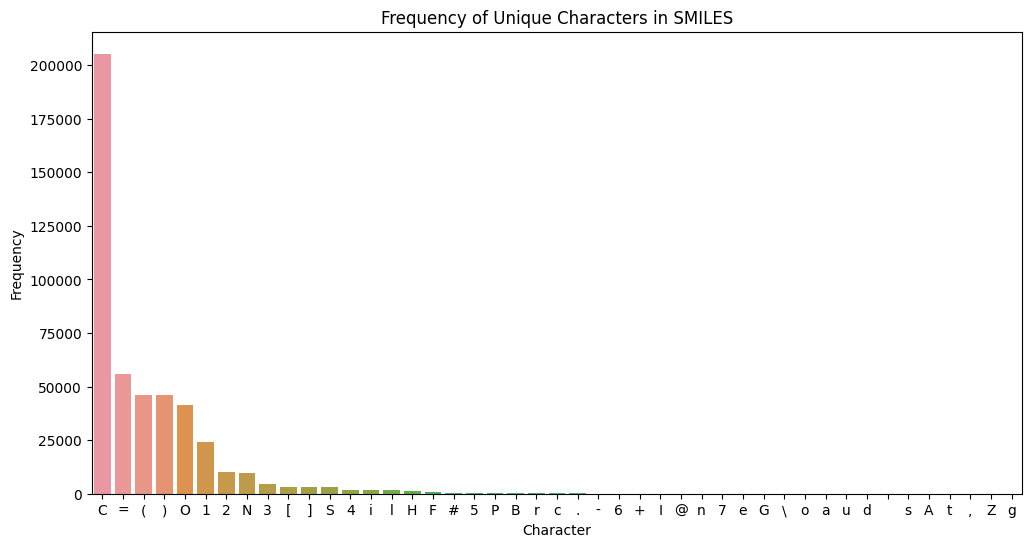

In [3]:
import csv
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# calculate character frequencies
char_counter = Counter()

with open('dataset/filtered_gc_spec.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        char_counter.update(row["SMILES"])

#convert to a sorted list of char counter and freq
char_freq = sorted(char_counter.items(), key=lambda item: item[1], reverse=True)
characters, frequencies = zip(*char_freq)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(characters), y=list(frequencies))

plt.title('Frequency of Unique Characters in SMILES')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.show()


In [4]:
# finding unique tuples in the spectral training data
unique_tuples = set()  

with open('dataset/filtered_gc_spec.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        spectrum_data = row["Spectrum"]
        tuples = spectrum_data.split() 
        for tup in tuples:
            if ':' in tup and tup.count(':') == 1: 
                unique_tuples.add(tup)

print(len(unique_tuples))  


517627


So we need to go from a "vocabulary" of 517627 unique tuples to 45 unique characters

In [5]:
# load input and output datasets for training

# load data
data = pd.read_csv('dataset/filtered_gc_spec.csv')
input_MS = pd.Series(data["Spectrum"][:18000])
output_SMILES = pd.Series(data["SMILES"][:18000])

assert len(input_MS) == len(output_SMILES)  # sanity check to ensure correct loading

# filter input by length of SMILES (<77 as per SMILES encoder)
output_SMILES_filtered = output_SMILES[output_SMILES.str.len() < 77]
input_MS_filtered = input_MS.loc[output_SMILES_filtered.index]

assert len(input_MS_filtered) == len(output_SMILES_filtered)  # sanity check to ensure correct filtering

print(f"Number of MS Spectra for input: {len(input_MS_filtered)}")
print(f"Number of SMILES sequences for output: {len(output_SMILES_filtered)}")


Number of MS Spectra for input: 17885
Number of SMILES sequences for output: 17885


## Converting to DeepSmiles and one hot encoding the SMILES output data

In [6]:
from deepsmiles import Converter
#use deepsmiles to convert the SMILES data

smiles_list = output_SMILES_filtered.tolist()

converter = Converter(rings=True, branches=True)
deepsmiles_list = [converter.encode(smi) for smi in smiles_list]

#now we've converted our input SMILES - will one hot encode 

print(deepsmiles_list[0:5])


deepsmiles_series = pd.Series(deepsmiles_list)

# filter input by length of DeepSMILES (<40 or >35 to minimize the padding tokens)
output_deepSMILES_filtered = deepsmiles_series[(deepsmiles_series.str.len() < 30) & (deepsmiles_series.str.len() > 25)]
input_MS_filtered = input_MS.loc[output_deepSMILES_filtered.index]

assert len(input_MS_filtered) == len(output_deepSMILES_filtered)  # sanity check to ensure correct filtering

print(f"Number of MS Spectra for input: {len(input_MS_filtered)}")
print(f"Number of SMILES sequences for output: {len(output_deepSMILES_filtered)}")

#okay, now we have 1575 samples that have a length between 25 and 30 to use for training. 

deepsmiles_list = output_deepSMILES_filtered.tolist()

['OCCC=CC=CC=6', 'OCCCCCCCCC=CCCCCCCCC', 'O=S=O)NCCCCCC6)))))))C=CC=CC=C6))C', 'O=S=O)N)C=CC=CC=C6))C', 'O=S=O)NCC)))CC=CC=CC=6C']
Number of MS Spectra for input: 1575
Number of SMILES sequences for output: 1575


In [7]:
#create vocabulary based on our input
#find unique characters in the deepsmiles_list

vocab = list(set(''.join(deepsmiles_list)))
vocab_size = len(vocab)

#create a dictionary based on key: char, val: index
vocab_dict = {char: idx for idx, char in enumerate(vocab)}

#define a unique padding index
padding_idx = len(vocab_dict) #using an index that's greater than any existing entries
vocab_dict['<PAD>'] = padding_idx #setting a unique padding string
idx_to_token = {idx: char for char, idx in vocab_dict.items()} #index to token for use in the tranformer
 
print(f"Vocab size based on our Deep SMILES input: {vocab_size}")

Vocab size based on our Deep SMILES input: 36


In [8]:
#defining a function to one-hot encode a single SMILES string
def ohe_smiles(smiles, vocab_dict, max_length):
    
    #pull out the indices based on the dictionary we created 
    indices = [vocab_dict[char] for char in smiles] 
    # pad so they're all the same length with our unique padding index 
    indices += [padding_idx] * (max_length - len(indices)) 
    # convert to tensor 
    indices_tensor = torch.tensor(indices, dtype=torch.long) 
    # one hot encode 
    ohe_tensor = F.one_hot(indices_tensor, num_classes=len(vocab_dict)).float() 
    return ohe_tensor 

#find the max length of deepSMILES in our data 
max_deepsmiles_length = max(len(smi) for smi in deepsmiles_list)
print(f"The Max DeepSMILES length is: {max_deepsmiles_length}")

min_deepsmiles_length = min(len(smi) for smi in deepsmiles_list)
print(f"The Min DeepSMILES length is: {min_deepsmiles_length}")



The Max DeepSMILES length is: 29
The Min DeepSMILES length is: 26


In [9]:
# ohe our data
ohe_smi = [ohe_smiles(smi, vocab_dict, max_deepsmiles_length) for smi in deepsmiles_list]
ohe_smi_tensor = torch.stack(ohe_smi).float()

# train/test split (using indices)
indices_tt = np.arange (len(deepsmiles_list)) #gives us indices for all the entries in smiles_lis
train_idx, test_idx = train_test_split(indices_tt, test_size=0.2, random_state=42)

#apply to SMILES data
deepsmiles_train = ohe_smi_tensor[train_idx]
deepsmiles_test = ohe_smi_tensor[test_idx]

# convert back to tensor and make sure they're the correct shape
deepsmiles_train = deepsmiles_train.clone().detach().type(torch.float32)
deepsmiles_test = deepsmiles_test.clone().detach().type(torch.float32)

print(f"Shape of training SMILES tensor: {deepsmiles_train.shape}")
print(f"Type of training SMILES tensor: {deepsmiles_train.dtype}")
print(f"Shape of testing SMILES tensor: {deepsmiles_test.shape}")
print(f"Type of training SMILES tensor: {(deepsmiles_test.dtype)}")

Shape of training SMILES tensor: torch.Size([1260, 29, 37])
Type of training SMILES tensor: torch.float32
Shape of testing SMILES tensor: torch.Size([315, 29, 37])
Type of training SMILES tensor: torch.float32


### Preparing the MS input data

In [ ]:
#creating a function to convert from spector to tensor

def spec_2_tensor(spectrum, max_length):
    #get tuples from input data
    spectrum_tuples = [(float(mz), float(intensity)) for mz, intensity in (item.split(":") for item in spectrum.split())]

    #normalize intensity to be between 0 and 1
    max_intensity = max(intensity for mz, intensity in spectrum_tuples)
    if max_intensity > 0:
        spectrum_tuples = [(mz, intensity / max_intensity) for mz, intensity in spectrum_tuples]


    #normalize m/z to be between 0 and 1
    max_mz = max(mz for mz, intensity in spectrum_tuples)
    if max_mz > 0:
        spectrum_tuples = [(mz / max_mz, intensity) for mz, intensity in spectrum_tuples]


    #pad to max length
    spectrum_tuples = spectrum_tuples[:max_length] + [(0, 0)] * (max_length - len(spectrum_tuples))

    return torch.tensor(spectrum_tuples, dtype=torch.float32)

#value from examining the data 
max_length = 300

#apply to our data
input_MS_combined = input_MS_filtered.apply(lambda x: spec_2_tensor(x, max_length))
ms_tensor_combined = torch.stack(input_MS_combined.tolist())

# train/test split using indices defined in SMILES prep step
ms_train = ms_tensor_combined[train_idx]
ms_test = ms_tensor_combined[test_idx]


# convert back to tensor and make sure they're the correct shape
ms_train = ms_train.clone().detach().type(torch.float32)
ms_test = ms_test.clone().detach().type(torch.float32)

#sanity check
print(f"Shape of training MS tensor: {ms_train.shape}")
print(f"Type of training MS tensor: {ms_train.dtype}")
print(f"Shape of testing MS tensor: {ms_test.shape}")
print(f"Type of training MS tensor: {(ms_test.dtype)}")

Shape of training MS tensor: torch.Size([1260, 300, 2])
Type of training MS tensor: torch.float32
Shape of testing MS tensor: torch.Size([315, 300, 2])
Type of training MS tensor: torch.float32


In [11]:
#create dataloaders for the transformer

batch_size = 16 #keeping batch size low otherwise meory issues

#concatenate input/output data
train_dataset = TensorDataset(deepsmiles_train, ms_train) 
test_dataset = TensorDataset(deepsmiles_test, ms_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)




## Defining Transformer

In [12]:
import torch
import torch.nn as nn
import math

# positional encoding necessary otherwise the transformer has no information about token's position
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len=max_deepsmiles_length):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2) * (-math.log(10000.0) / dim_model))
        pe = torch.zeros(1, max_len, dim_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, num_tokens, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p):
        super().__init__()

        self.model_type = "Transformer"
        self.dim_model = dim_model

        self.positional_encoder_ms = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=300) 
        self.positional_encoder_deep_smiles = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=max_deepsmiles_length)  
        #self.positional_encoder = PositionalEncoding(dim_model=dim_model, dropout_p=dropout_p, max_len=max_deepsmiles_length)
        self.embedding = nn.Linear(num_tokens, dim_model)
        #embedding for ms because it has 2 features
        self.ms_embedding = nn.Linear(2, dim_model)

        self.transformer = nn.Transformer(
            d_model=dim_model, 
            nhead=num_heads, 
            num_encoder_layers=num_encoder_layers, 
            num_decoder_layers=num_decoder_layers, 
            dropout=dropout_p, 
            batch_first=True  # setting this to True for nested tensors, error otherwise
        )
        self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        
        # embed and apply positional encoding for MS data
        src = self.ms_embedding(src).float() * math.sqrt(self.dim_model)  
        src = self.positional_encoder_ms(src)  # Apply MS positional encoding
        
        # had a type mismatch so making sure both embeddings are in float
        #src = self.ms_embedding(src).float() * math.sqrt(self.dim_model)  
        #src = self.positional_encoder(src)
        
        # embed and apply positional encoding for DeepSMILES
        tgt = self.embedding(tgt).float() * math.sqrt(self.dim_model) 
        tgt = self.positional_encoder_deep_smiles(tgt)  # Apply DeepSMILES positional encoding

        
        #tgt = self.embedding(tgt).float() * math.sqrt(self.dim_model) 
        #tgt = self.positional_encoder(tgt)

        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)
        
        return out
    
    #target mask is to the the tranformer attends to the previous token and ignores future tokens
    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1)
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf'))
        mask = mask.masked_fill(mask == 1, float(0.0))
        return mask
    
    #create a padding mask for the DeepSmiles data so the padding is ignored by the transformer
    def create_pad_mask_deepsmiles(self, matrix: torch.tensor, pad_token: str = '<PAD>') -> torch.tensor:
        pad_index = vocab_dict['<PAD>'] #find index for our padding token
        return (matrix.argmax(dim=-1) == pad_index)
    
    #create a padding mask for the MS data so the padding is ignored by the transformer
    def create_pad_mask_ms(self, src, pad_value=0):
        pad_mask = ms_batch[:, :, 0] != pad_value  
        return pad_mask  

### Defining model parameters

In [21]:
#can change optimizer, dim_model, num_heads, num encoder/decoder layers, and dropout %
num_tokens = ohe_smi_tensor.shape[-1]
model = Transformer(num_tokens=num_tokens, dim_model=512, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, dropout_p=0.1)
criterion = nn.CrossEntropyLoss()

#can tune LR for Adam if necessary
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

#use my original dictionary (vocab_dict)
idx_to_token = {idx: char for char, idx in vocab_dict.items()}

#need this function to decode the smiles 
def decode_smiles(token_indices, idx_to_token, padding_idx):
    smiles = ''.join([idx_to_token[idx] for idx in token_indices if idx != padding_idx and idx != -1])
    return smiles

In [137]:
from torchmetrics import Accuracy, F1Score

#initialize from torchmetrics 
train_accuracy = Accuracy(task='multiclass', num_classes=num_tokens)
train_f1 = F1Score(task='multiclass', num_classes=num_tokens, average='weighted')
val_accuracy = Accuracy(task='multiclass', num_classes=num_tokens)
val_f1 = F1Score(task='multiclass', num_classes=num_tokens, average='weighted')

# training loop
for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    train_accuracy.reset()
    train_f1.reset()

    for batch in train_loader:
        smiles_batch, ms_batch = batch
        
        # zero the gradient for the batch 
        optimizer.zero_grad()
        
        # get target input and output
        tgt_input = smiles_batch[:, :-1, :]  # all tokens from the smiles_batch (input to decoder)
        tgt_output = smiles_batch[:, 1:, :]  # next token that needs to be predicted

        # convert each ohe vector to a token index
        tgt_output = tgt_output.argmax(dim=-1)
        
        # mask target sequence (prevent from attending to future tokens - masks out future tokens)
        tgt_pad_mask = model.create_pad_mask_deepsmiles(tgt_input, '<PAD>')
        
        #padding mask for output data
        tgt_mask = model.get_tgt_mask(tgt_input.size(1))

        #padding mask for input data
        ms_pad_mask = model.create_pad_mask_ms(ms_batch, pad_value=0)

        #print(f"ms_batch shape: {ms_batch.shape}")
        #print(f"ms_pad_mask shape: {ms_pad_mask.shape}")
        #print(f"tgt_input shape: {tgt_input.shape}")
        #print(f"tgt_pad_mask shape: {tgt_pad_mask.shape}")
        
        # forward pass
        output = model(ms_batch, tgt_input, tgt_mask=tgt_mask, src_pad_mask=ms_pad_mask, tgt_pad_mask = tgt_pad_mask)
        
        # for debugging
        #print("Output shape before reshape:", output.shape)  # Should be [batch_size, seq_len, vocab_size]
        #print("Target output shape before reshape:", tgt_output.shape)  # Should be [batch_size, seq_len]

        # reshaping for loss function
        output = output.reshape(-1, len(vocab_dict))  # (batch_size * seq_len), vocab_size
        tgt_output = tgt_output.view(-1)  #batch_size * seq_len

        # for debugging
        #print("reshaped Output shape:", output.shape)
        #print("reshaped Target output shape:", tgt_output.shape)
        
        # loss, accuracy, f1 
        loss = criterion(output, tgt_output.long())  
        total_loss += loss.item()

        train_accuracy.update(output.argmax(dim=-1), tgt_output)
        train_f1.update(output.argmax(dim=-1), tgt_output)
        
        # backpropagation, optimizer step
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = train_accuracy.compute()
    train_f1_score = train_f1.compute()


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Train F1: {train_f1_score:.4f}")
          
    # decode and print original SMILES/predicted DeepSmiles
    original_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in smiles_batch.argmax(dim=-1).tolist()]
    predicted_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in output.argmax(dim=-1).view(smiles_batch.size(0), smiles_batch.size(1)-1).tolist()]
    for original_smiles, predicted_smiles in zip(original_smiles_list, predicted_smiles_list):
        print(f"Original DeepSMILES: {original_smiles}")
        print(f"Predicted DeepSMILES: {predicted_smiles}")


/home/marieanand/miniconda3/envs/msse-python/lib/python3.11/site-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/50], Train Loss: 1.8896, Train Accuracy: 0.4298, Train F1: 0.2798
Original DeepSMILES: O=CC=O)C=CC=CC=CC=CC%11=C6%10
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=CC=CC=COC))C=C6O)))))))C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=CCCCCC6CCCC)))CC4C[Si]C)C)C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COCCC=CC=CC=6))))))))CCC
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: NC=CC=CC=CCC=CC=NC=6C=%14%10
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COCC=C))C)CCC=CC)C)))))))C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: [H]C[H])CCCC[H])[H])[SiH]6C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COCCCC)))))CCCCC=O)OCCCC
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=CO)CN)CC=CNCC=CCO)=CC=69
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=

In [ ]:
    #save model after training
    #torch.save(model, 'model.pt')

    

    #loading model
    #model = torch.load('model.pt')
    

/tmp/ipykernel_1034/1340141317.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')


In [22]:
from torchmetrics import Accuracy, F1Score


#train for another 150 epochs
num_epochs=200

#initialize from torchmetrics 
train_accuracy = Accuracy(task='multiclass', num_classes=num_tokens)
train_f1 = F1Score(task='multiclass', num_classes=num_tokens, average='weighted')
val_accuracy = Accuracy(task='multiclass', num_classes=num_tokens)
val_f1 = F1Score(task='multiclass', num_classes=num_tokens, average='weighted')

# training loop
for epoch in range(num_epochs):
    model.train()

    total_loss = 0
    train_accuracy.reset()
    train_f1.reset()

    for batch in train_loader:
        smiles_batch, ms_batch = batch
        
        # zero the gradient for the batch 
        optimizer.zero_grad()
        
        # get target input and output
        tgt_input = smiles_batch[:, :-1, :]  # all tokens from the smiles_batch (input to decoder)
        tgt_output = smiles_batch[:, 1:, :]  # next token that needs to be predicted

        # convert each ohe vector to a token index
        tgt_output = tgt_output.argmax(dim=-1)
        
        # mask target sequence (prevent from attending to future tokens - masks out future tokens)
        tgt_pad_mask = model.create_pad_mask_deepsmiles(tgt_input, '<PAD>')
        
        #padding mask for output data
        tgt_mask = model.get_tgt_mask(tgt_input.size(1))

        #padding mask for input data
        ms_pad_mask = model.create_pad_mask_ms(ms_batch, pad_value=0)

        #print(f"ms_batch shape: {ms_batch.shape}")
        #print(f"ms_pad_mask shape: {ms_pad_mask.shape}")
        #print(f"tgt_input shape: {tgt_input.shape}")
        #print(f"tgt_pad_mask shape: {tgt_pad_mask.shape}")
        
        # forward pass
        output = model(ms_batch, tgt_input, tgt_mask=tgt_mask, src_pad_mask=ms_pad_mask, tgt_pad_mask = tgt_pad_mask)
        
        # for debugging
        #print("Output shape before reshape:", output.shape)  # Should be [batch_size, seq_len, vocab_size]
        #print("Target output shape before reshape:", tgt_output.shape)  # Should be [batch_size, seq_len]

        # reshaping for loss function
        output = output.reshape(-1, len(vocab_dict))  # (batch_size * seq_len), vocab_size
        tgt_output = tgt_output.view(-1)  #batch_size * seq_len

        # for debugging
        #print("reshaped Output shape:", output.shape)
        #print("reshaped Target output shape:", tgt_output.shape)
        
        # loss, accuracy, f1 
        loss = criterion(output, tgt_output.long())  
        total_loss += loss.item()

        train_accuracy.update(output.argmax(dim=-1), tgt_output)
        train_f1.update(output.argmax(dim=-1), tgt_output)
        
        # backpropagation, optimizer step
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = train_accuracy.compute()
    train_f1_score = train_f1.compute()


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, Train F1: {train_f1_score:.4f}")
          
    # decode and print original SMILES/predicted DeepSmiles
    original_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in smiles_batch.argmax(dim=-1).tolist()]
    predicted_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in output.argmax(dim=-1).view(smiles_batch.size(0), smiles_batch.size(1)-1).tolist()]
    for original_smiles, predicted_smiles in zip(original_smiles_list, predicted_smiles_list):
        print(f"Original DeepSMILES: {original_smiles}")
        print(f"Predicted DeepSMILES: {predicted_smiles}")


Epoch [1/200], Train Loss: 1.9085, Train Accuracy: 0.4254, Train F1: 0.2814
Original DeepSMILES: O=COCC=CCCC)C6))))CC)C)))))C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: OCC))[Si]OCC)))OCC)))CCCCCCCC
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: C=CC)CCC=CC)CCC=CC)C))C%10
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COCC=CC)CCC=CC)C)))))))))CC
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: C=CCCCC=C)CCC=CC)C))))))CC6
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COC))C=COCO)CC=CCC95)))CO
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=COCCCC=CC=CC=6)))))))))C
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: OCC)CCCCC)CCCC=C)C))CC%106
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: O=CN=CO)C=CN6COCCO))CO)C5O
Predicted DeepSMILES: CCCCCCCCCCCCCCCCCCCCCCCCCCCC
Original DeepSMILES: OC

KeyboardInterrupt: 

In [23]:
    #save model after training
    torch.save(model, 'model_150.pt')

In [29]:

    # validation loop
    model.eval()
    total_val_loss = 0
    val_accuracy.reset()
    val_f1.reset()

    with torch.no_grad():
        for batch in test_loader:
            smiles_batch, ms_batch = batch
            
            tgt_input = smiles_batch[:, :-1, :]
            tgt_output = smiles_batch[:, 1:, :]
            
            tgt_output = tgt_output.argmax(dim=-1)
            
            tgt_mask = model.get_tgt_mask(tgt_input.size(1))
            
            output = model(ms_batch, tgt_input, tgt_mask=tgt_mask)
            
            output = output.reshape(-1, len(vocab_dict))
            tgt_output = tgt_output.view(-1)   
            
            loss = criterion(output, tgt_output.long())
            total_val_loss += loss.item()
            
            val_accuracy.update(output.argmax(dim=-1), tgt_output)
            val_f1.update(output.argmax(dim=-1), tgt_output)
            
            # Decode and print original and predicted DeepSMILES for validation
            original_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in smiles_batch.argmax(dim=-1).tolist()]
            predicted_smiles_list = [decode_smiles(seq, idx_to_token, padding_idx) for seq in output.argmax(dim=-1).view(smiles_batch.size(0), smiles_batch.size(1)-1).tolist()]
            for original_smiles, predicted_smiles in zip(original_smiles_list, predicted_smiles_list):
                print(f"Original DeepSMILES: {original_smiles}")
                print(f"Predicted DeepSMILES: {predicted_smiles}")

    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = val_accuracy.compute()
    val_f1_score = val_f1.compute()

    print(f"The average validation loss is: {avg_val_loss}")
    print(f"The validation accuracy is: {val_acc}")
    print(f"The validation F1 score is: {val_f1_score}")

Original DeepSMILES: O=COCCCl)=CC=CC=6Cl))))))))C
Predicted DeepSMILES: ============================
Original DeepSMILES: Cl[Si]C=CC=CC=C6))C)))))C)CC
Predicted DeepSMILES: ============================
Original DeepSMILES: O=COCCCCCCOC=O)CCCCCCCCCC%20
Predicted DeepSMILES: ============================
Original DeepSMILES: OCC=CC=CC=6C)))))C)))CCN)C
Predicted DeepSMILES: ============================
Original DeepSMILES: O=COCCCCCCCCCC=C))))))))))))C
Predicted DeepSMILES: ============================
Original DeepSMILES: CCCCCC5CCCCCCCCC6C)C%10CC%17
Predicted DeepSMILES: ============================
Original DeepSMILES: O=CC=CC=COC=O)C)))COC))=C6
Predicted DeepSMILES: ============================
Original DeepSMILES: O=CC=CC=CC=C7NC)))CCCCCCCC%13
Predicted DeepSMILES: ============================
Original DeepSMILES: O=CCC=CC=CC=6))))))CC=CC=CC=6
Predicted DeepSMILES: ============================
Original DeepSMILES: O=COC))C=CO)C=CCC=CC=CC=6%10
Predicted DeepSMILES: ====================

In [26]:
import re

#extract data from training output using RegEx, as I neglected to save the epoch-wise metrics

epochs = []
train_losses = []
train_accuracies = []
train_f1_scores = []

#function to extract the epoch, train loss, train accuracy, train f1 line by line
def extract_metrics(line):
    epoch_match = re.search(r'Epoch \[(\d+)/', line)
    loss_match = re.search(r'Train Loss: ([\d.]+)', line)
    accuracy_match = re.search(r'Train Accuracy: ([\d.]+)', line)
    f1_match = re.search(r'Train F1: ([\d.]+)', line)

    if epoch_match and loss_match and accuracy_match and f1_match:
        epoch = int(epoch_match.group(1))
        loss = float(loss_match.group(1))
        accuracy = float(accuracy_match.group(1))
        f1 = float(f1_match.group(1))
        return epoch, loss, accuracy, f1
    return None

with open('train_output.csv', 'r') as file:
    for line in file:
        metrics = extract_metrics(line)
        if metrics:
            epoch, loss, accuracy, f1 = metrics
            epochs.append(epoch)
            train_losses.append(loss)
            train_accuracies.append(accuracy)
            train_f1_scores.append(f1)

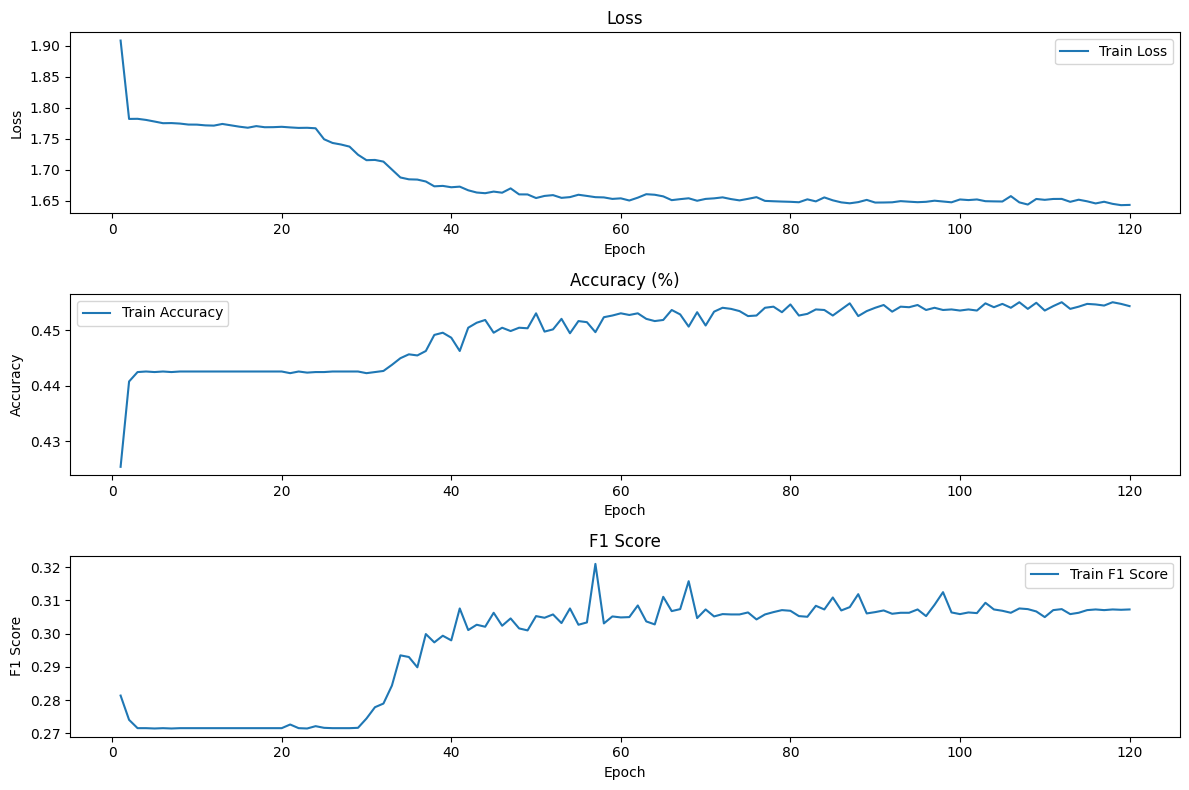

In [ ]:
plt.figure(figsize=(12, 8))

#loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# accuracy
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy (%)')
plt.legend()

# f1 score
plt.subplot(3, 1, 3)
plt.plot(epochs, train_f1_scores, label='Train F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()